In [85]:
import pandas as pd
import urllib2
import json
import io
import os
import networkx as nx
import re
import matplotlib.pyplot as plt
import numpy as np
from fa2 import ForceAtlas2
import mwparserfromhell
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import random
import community

%matplotlib inline
plt.style.use('ggplot')

In [68]:
df = pd.read_csv(os.path.join('data', 'character.csv'))

In [69]:
df.head()

,Unnamed: 0,page_id,title,House
0,0,33349,Astrix Alixan,Gryffindors
1,1,33353,Filemina Alchin,Gryffindors
2,2,7018,Euan Abercrombie,Gryffindors
3,3,99282,Sakura Akagi,Gryffindors
4,4,99036,Zakir Akram,Gryffindors


In [70]:
basequery = 'http://harrypotter.wikia.com/api.php?action=query&format=json&prop=revisions&rvprop=content'

def create_query(pageid):
    return basequery+'&pageids='+str(pageid)

In [71]:
def format_filename(name):
    return os.path.join('data/%s.json') % (name)

def dump_file(name, data):
    file_name = format_filename(name)
    with io.open(file_name, "w", encoding="utf-8") as f:
        f.write(unicode(json.dumps(data, ensure_ascii=False)))
    print("Wrote file: %s" % (file_name))

In [73]:
for pageid in df['page_id']:
    query = create_query(pageid)
    response =  urllib2.urlopen(query)
    response_dict = json.loads(response.read())
    for k in response_dict['query']['pages'].keys():
        dump_file(pageid, response_dict['query']['pages'][k]['revisions'][-1]['*'])

Wrote file: data/33349.json
Wrote file: data/33353.json
Wrote file: data/7018.json
Wrote file: data/99282.json
Wrote file: data/99036.json
Wrote file: data/123475.json
Wrote file: data/59171.json
Wrote file: data/59173.json
Wrote file: data/59193.json
Wrote file: data/59177.json
Wrote file: data/28767.json
Wrote file: data/33354.json
Wrote file: data/98807.json
Wrote file: data/99269.json
Wrote file: data/33408.json
Wrote file: data/325.json
Wrote file: data/99052.json
Wrote file: data/8259.json
Wrote file: data/99277.json
Wrote file: data/197956.json
Wrote file: data/197957.json
Wrote file: data/36003.json
Wrote file: data/31.json
Wrote file: data/197958.json
Wrote file: data/37634.json
Wrote file: data/46445.json
Wrote file: data/137536.json
Wrote file: data/46451.json
Wrote file: data/99236.json
Wrote file: data/20.json
Wrote file: data/890.json
Wrote file: data/161113.json
Wrote file: data/98813.json
Wrote file: data/192662.json
Wrote file: data/197960.json
Wrote file: data/123479.

Wrote file: data/161937.json
Wrote file: data/201457.json
Wrote file: data/99630.json
Wrote file: data/208585.json
Wrote file: data/205930.json
Wrote file: data/35207.json
Wrote file: data/7035.json
Wrote file: data/96953.json
Wrote file: data/96954.json
Wrote file: data/46384.json
Wrote file: data/90770.json
Wrote file: data/410.json
Wrote file: data/99637.json
Wrote file: data/100468.json
Wrote file: data/185195.json
Wrote file: data/7034.json
Wrote file: data/947.json
Wrote file: data/34875.json
Wrote file: data/99618.json
Wrote file: data/99619.json
Wrote file: data/38278.json
Wrote file: data/6874.json
Wrote file: data/34737.json
Wrote file: data/4483.json
Wrote file: data/5092.json
Wrote file: data/7039.json
Wrote file: data/328.json
Wrote file: data/7030.json
Wrote file: data/100481.json
Wrote file: data/89466.json
Wrote file: data/34449.json
Wrote file: data/99620.json
Wrote file: data/2836.json
Wrote file: data/99621.json
Wrote file: data/99622.json
Wrote file: data/39000.json

Wrote file: data/3816.json
Wrote file: data/83.json
Wrote file: data/2762.json
Wrote file: data/36334.json
Wrote file: data/865.json
Wrote file: data/36.json
Wrote file: data/6310.json
Wrote file: data/192663.json
Wrote file: data/82797.json
Wrote file: data/161921.json
Wrote file: data/161975.json
Wrote file: data/100502.json
Wrote file: data/35220.json
Wrote file: data/35967.json
Wrote file: data/679.json
Wrote file: data/14699.json
Wrote file: data/18212.json
Wrote file: data/18211.json
Wrote file: data/34879.json
Wrote file: data/34891.json
Wrote file: data/547.json
Wrote file: data/44396.json
Wrote file: data/34860.json
Wrote file: data/44389.json
Wrote file: data/198022.json
Wrote file: data/100531.json
Wrote file: data/126518.json
Wrote file: data/7055.json
Wrote file: data/34865.json
Wrote file: data/3389.json
Wrote file: data/42332.json
Wrote file: data/35115.json
Wrote file: data/96195.json
Wrote file: data/77774.json
Wrote file: data/77775.json
Wrote file: data/35154.json
Wr

In [74]:
regex = "\[\[(.*?)\]\]"

character_name = np.array(df.title)

G = nx.DiGraph()
for index, row in df.iterrows():
    G.add_node(row['title'], house=row['House'], pageid=row['page_id'])

for index, row in df.iterrows():
    with io.open(format_filename(row['page_id']), 'r', encoding='utf-8') as f:
        content = json.load(f)
    links = re.findall(regex, content)
    
    for link in links:
        for l in link.split('|'): 
            if l in character_name:
                G.add_edge(row['title'], l)

In [75]:
print("Nodes: {}".format(len(G.nodes)))
print("Edges: {}".format(len(G.edges)))

Nodes: 851
Edges: 4495


In [76]:
def calculate_position(G):
    forceatlas2 = ForceAtlas2(scalingRatio=1.0,
                              strongGravityMode=False,
                              gravity=50.0,
                              verbose=False)
    return forceatlas2.forceatlas2_networkx_layout(nx.Graph(G), pos=None, iterations=3000)

In [77]:
house_color_dict = {
    'Gryffindors': '#740001',
    'Hufflepuffs': '#ecb939',
    'Slytherins': '#3d6b58',
    'Ravenclaws': '#222f5b',
    'Unknown_House': 'gray'
}

positions = calculate_position(G)
node_degree = [G.degree(n)*0.8+1 for n in G.nodes]
node_colors = [house_color_dict[v['house']] for k, v in G.nodes.data()]

In [79]:
# Add position, color and size as node attributes to dump it as GEXF file
for k, v in G.nodes(data=True):
    G.nodes[k]['x'] = positions[k][0]
    G.nodes[k]['y'] = positions[k][1]
    G.nodes[k]['color'] = house_color_dict[v['house']]
    G.nodes[k]['size'] = G.degree(k)*0.8+1

nx.write_gexf(G, os.path.join("docs", "resources", "graph.gexf"))

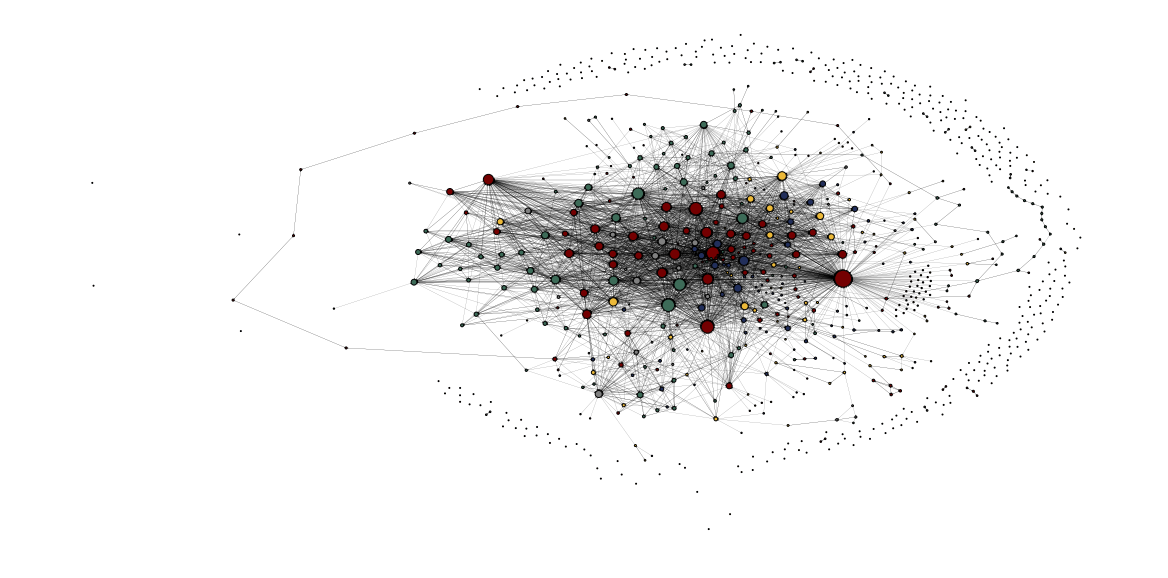

In [80]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G, positions, 
                 cmap=plt.get_cmap('jet'), 
                 node_size=node_degree, 
                 node_color=node_colors, 
                 arrows = True,
                 width = 0.1,
                 with_labels=False,
                 linewidths=1., 
                 arrowsize=2)
plt.gca().collections[0].set_edgecolor("#000000")
plt.axis('off')

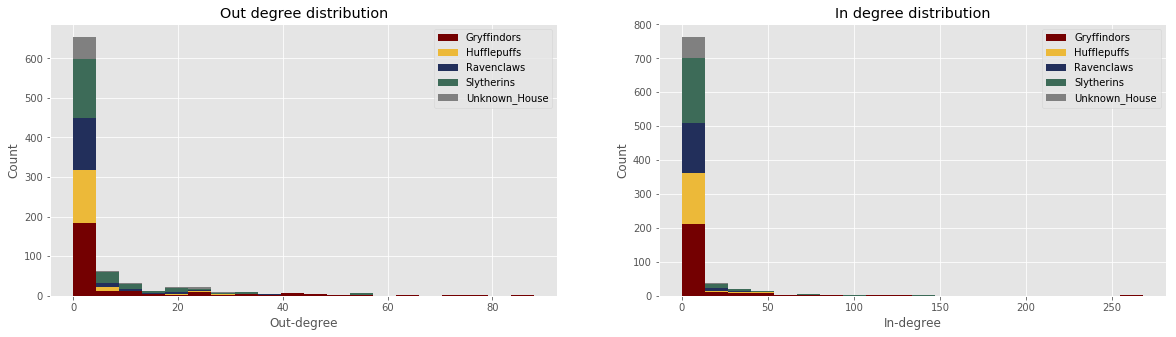

In [81]:
color_list = [v for h, v in house_color_dict.iteritems()]

in_degrees = [sorted([G.in_degree(k) for k, v in G.nodes.data() if v['house'] == h], reverse=True) \
              for h, _ in house_color_dict.iteritems()]
out_degrees = [sorted([G.out_degree(k) for k, v in G.nodes.data() if v['house'] == h], reverse=True) \
              for h, _ in house_color_dict.iteritems()]

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(out_degrees, bins = 20, stacked=True, color=color_list)
plt.title('Out degree distribution')
plt.xlabel('Out-degree')
plt.ylabel('Count')
plt.legend(house_color_dict)
plt.subplot(122)
plt.hist(in_degrees, bins = 20, stacked=True, color=color_list)
plt.title('In degree distribution')
plt.xlabel('In-degree')
plt.ylabel('Count')
plt.legend(house_color_dict)

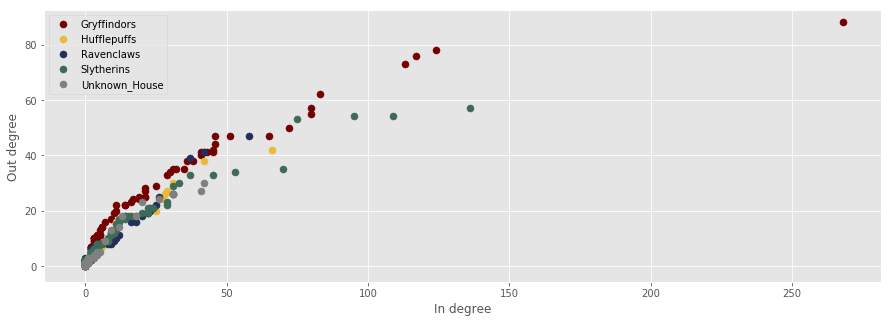

In [82]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
for i, c in enumerate(house_color_dict.itervalues()):
    scatter = ax.scatter(in_degrees[i], out_degrees[i], c=color_list[i],s=50)
plt.xlabel('In degree')
plt.ylabel('Out degree')
plt.legend(house_color_dict)

Text(0.5,1,'In degree - log scale')

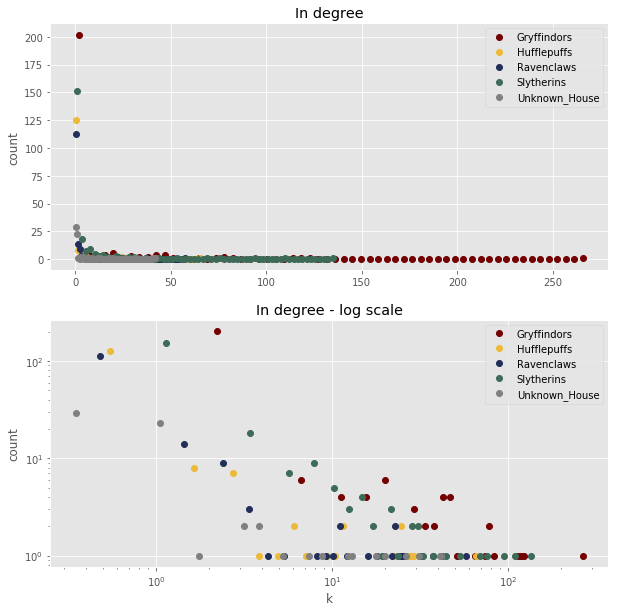

In [83]:
hists = [np.histogram(i, 60) for i in in_degrees]
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for i, h in enumerate(hists):
    plt.plot(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.ylabel("count")
plt.title('In degree')
plt.legend(house_color_dict)
plt.subplot(2,1,2)
plt.xlabel("k")
plt.ylabel("count")
for i, h in enumerate(hists):
    plt.loglog(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.legend(house_color_dict)
plt.title('In degree - log scale')


Text(0.5,1,'Out degree - log scale')

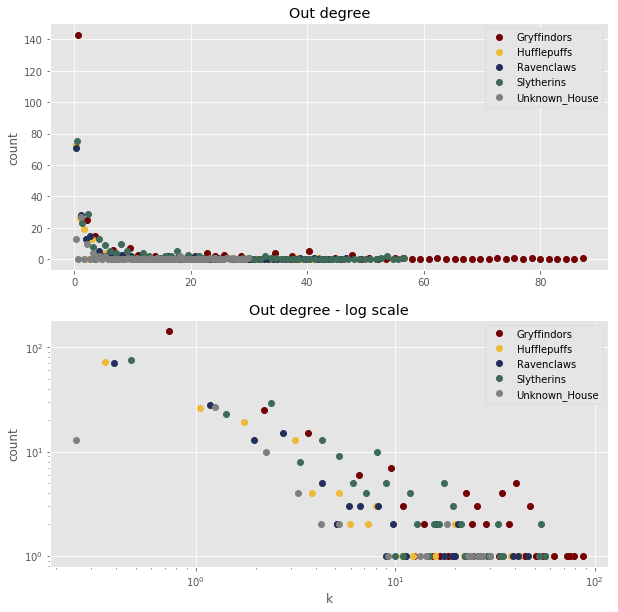

In [84]:
hists = [np.histogram(i, 60) for i in out_degrees]
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for i, h in enumerate(hists):
    plt.plot(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.ylabel("count")
plt.title('Out degree')
plt.legend(house_color_dict)
plt.subplot(2,1,2)
plt.xlabel("k")
plt.ylabel("count")
for i, h in enumerate(hists):
    plt.loglog(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.legend(house_color_dict)
plt.title('Out degree - log scale')

In [111]:
# Store JSON-file to view centralities as a table
dicts = []
bc = nx.betweenness_centrality(G)
ec = nx.eigenvector_centrality(G)
count = 1
for n in G.nodes:
    dicts.append({'id': count,
                    'name': n,
                    'bc': round(bc[n], 4),
                   'ec': round(ec[n], 4),
                   'in_degree': G.in_degree(n),
                   'out_degree': G.out_degree(n)})
    count +=1

In [112]:
with open(os.path.join('docs', 'resources', 'data.json'), 'w') as f:
    json.dump(dicts, f)

## Community Detection
As many of the nodes don't have the edges, we remove those to be able to inspect the communities more closely.

In [86]:
nd_G = nx.Graph(G)
# Remove nodes with no edges
nd_G.remove_nodes_from(list(nx.isolates(nd_G)))
partition = community.best_partition(nd_G)
print("The modularity of the partition is {}".format(community.modularity(partition, nd_G)))

The modularity of the partition is 0.322676329356


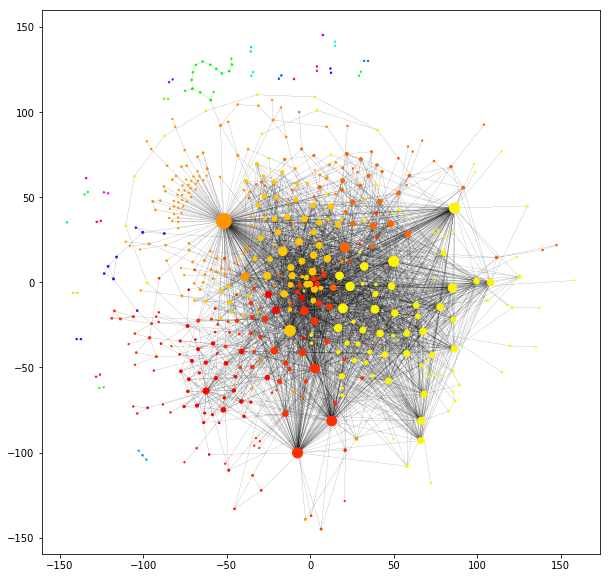

In [38]:
plt.figure(figsize=(10,10))
node_degree = [nd_G.degree(n)*0.8+1 for n in nd_G.nodes]
node_colors = [partition[n] for n in nd_G.nodes]
nx.draw_networkx(nd_G, positions,
                 cmap=plt.get_cmap('hsv'),
                 node_size=node_degree, 
                 node_color=node_colors, 
                 arrows = False,
                 width = 0.1,
                 with_labels=False)

In [103]:
# Add position, color and size as node attributes to dump it as GEXF file
for k, v in nd_G.nodes(data=True):
    nd_G.nodes[k]['x'] = positions[k][0]
    nd_G.nodes[k]['y'] = positions[k][1]
    c = colormap(partition[k]*30)
    nd_G.nodes[k]['color'] = 'rgb({},{},{})'.format(int(c[0]*255), int(c[1]*255), int(c[2]*255))
    nd_G.nodes[k]['size'] = nd_G.degree(k)*0.8+1

nx.write_gexf(nd_G, os.path.join("resources", "community_graph.gexf"))

In [104]:
nd_G.nodes['Harry Potter']

{'color': 'rgb(0,255,21)',
 'house': 'Gryffindors',
 'pageid': 13,
 'size': 220.20000000000002,
 'x': -56.36694731332893,
 'y': 8.885173060461463}

Disregard communities with only a single node in them

In [13]:
node_dict = {'Gryffindors' : [k for k, v in G.nodes.data() if v['house'] == 'Gryffindors'],
             'Hufflepuffs' : [k for k, v in G.nodes.data() if v['house'] == 'Hufflepuffs'],
            'Slytherins' : [k for k, v in G.nodes.data() if v['house'] == 'Slytherins'],
             'Ravenclaws' : [k for k, v in G.nodes.data() if v['house'] == 'Ravenclaws'],
             'Unknown_House' : [k for k, v in G.nodes.data() if v['house'] == 'Unknown_House']
}

In [40]:
B = len(node_dict.keys())
C = len(set(partition.values()))
D = np.zeros((B, C))

count = 0
for k, v in node_dict.iteritems():
    p = np.array([partition[n] for n in v])
    for i in range(C):
        D[count, i] = sum(p == i)
    count += 1

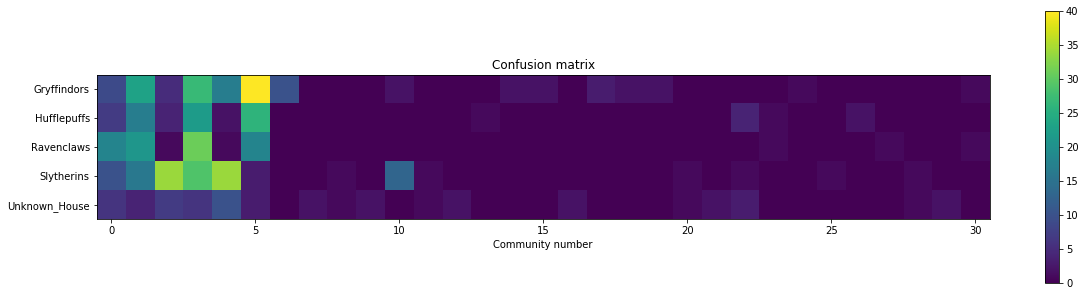

In [41]:
plt.figure(figsize=(20,5))
plt.imshow(D)
plt.xlabel('Community number')
plt.yticks(np.arange(B), list(node_dict.keys()))
plt.title('Confusion matrix')
plt.colorbar()

In [71]:
COMMUNITIES_TO_INVESTIGATE = 5
TOP5 = 10

for i in range(COMMUNITIES_TO_INVESTIGATE):
    print("============== Top {} highest degrees in community {} ============== ".format(TOP5, i))
    nodes = [k for k, v in partition.iteritems() if v == i]
    top_nodes = sorted(nodes, key=lambda x: G.degree(x), reverse=True)[:TOP5]
    for node in top_nodes:
        print('{:<25}  {:<25} Degree: {:<20}'.format(node, nd_G.nodes.data()[node]['house'], nd_G.degree[node]))

============== Top 10 highest degrees in community 0 ============== 
William Weasley            Gryffindors               Degree: 52                  
Charles Weasley            Gryffindors               Degree: 41                  
Jacob's sibling            Unknown_House             Degree: 44                  
Garrick Ollivander         Ravenclaws                Degree: 32                  
Merula Snyde               Slytherins                Degree: 25                  
Patricia Rakepick          Gryffindors               Degree: 26                  
Bloody Baron               Slytherins                Degree: 23                  
Jacob (Hogwarts student)   Unknown_House             Degree: 15                  
Xenophilius Lovegood       Ravenclaws                Degree: 15                  
Ben Copper                 Gryffindors               Degree: 14                  
============== Top 10 highest degrees in community 1 ============== 
Albus Dumbledore           Gryffindors    

### Preprocess wiki text

In [10]:
stopword_list = stopwords.words('english')
stopword_list = stopword_list + [sw.replace('\'', '') for sw in stopword_list]

def tokenize_document(file_name):
    # Load the file, parse it using mwparserfromhell, convert to lowercase, remove stopwords and punctuation
    with io.open(file_name, 'r', encoding='utf-8') as f:
        d = f.read()
        w = mwparserfromhell.parse(d)
        w = w.strip_code().lower()
        tokens = nltk.word_tokenize(w)
        tokens = [t for t in tokens if t not in stopword_list]
        tokens = [t for t in tokens if t not in string.punctuation+'=='+'\'s'+'``'+'\'\'']
        tokens = [t for t in tokens if t if t.isalpha()]
        tokens = [t for t in tokens if t if not len(t) == 1]
        return tokens

In [11]:
token_dict = {row[1].title: tokenize_document(format_filename(row[1].page_id)) for row in df.iterrows()}

## Sentiment analysis - on each house

In [47]:
word_list_df = pd.read_csv(os.path.join('data', 'sentiment-list.txt'),delimiter='\t', skiprows=3)
word_list_df.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [48]:
#Creating dictionary for all words and their happiness average.
happy_dict = {}
for idx, row in word_list_df.iterrows():
    happy_dict[row.word] = row.happiness_average

In [49]:
words = set(word_list_df.word)
mean_happniess = np.mean(word_list_df.happiness_average)

def calculate_sentiment(tokens):
    tsum = 0.
    count = 0.
    for t in tokens:
        if t in words:
            tsum += happy_dict[t]
            count += 1
    if tsum == 0:
        return mean_happniess
    return tsum/count

In [50]:
sentiment_dict = {k: calculate_sentiment(v) for k, v in token_dict.iteritems()}

In [57]:
def print_list(top, d):
    print("{:<60}  | {:<30}  | {}".format("Character", "Sentiment", "House"))
    print("-"*110)
    for t in top:
        print("{:<60}  | {:<30}  | {}".format(t, d[t], G.nodes.data()[t]['house']))

In [58]:
top = sorted(sentiment_dict.keys(), key = lambda x: sentiment_dict[x], reverse=True)[:10]
print("==================== Top 10 highest sentiment characters ====================")
print_list(top, sentiment_dict)

==================== Top 10 highest sentiment characters ====================
Character                                                     | Sentiment                       | House
--------------------------------------------------------------------------------------------------------------
Hufflepuff boy that blames Harry Potter (I)                   | 6.41142857143                   | Hufflepuffs
Slytherin student that blames Harry Potter (I)                | 6.3925                          | Slytherins
Hufflepuff boy that blames Harry Potter (II)                  | 6.3925                          | Hufflepuffs
Slytherin student that blames Harry Potter (II)               | 6.3925                          | Slytherins
Oona Ballington                                               | 6.36                            | Gryffindors
Filemina Alchin                                               | 6.2875                          | Gryffindors
Unidentified Ravenclaw boy at Hogwarts           

In [59]:
top = sorted(sentiment_dict.keys(), key = lambda x: sentiment_dict[x], reverse=False)[:10]
print("==================== Top 10 loweset sentiment characters ====================")
print_list(top, sentiment_dict)

==================== Top 10 loweset sentiment characters ====================
Character                                                     | Sentiment                       | House
--------------------------------------------------------------------------------------------------------------
Unidentified Ravenclaw boy (III)                              | 4.53333333333                   | Ravenclaws
Wilkes                                                        | 4.56240740741                   | Slytherins
Unidentified Slytherin girl at the Battle of Hogwarts (III)   | 4.66181818182                   | Slytherins
Unidentified Slytherin girl at the Battle of Hogwarts         | 4.76                            | Slytherins
Unidentified Hogwarts Hufflepuff boy who carried a body during the Battle of Hogwarts  | 4.78                            | Hufflepuffs
Summerby                                                      | 4.81448275862                   | Hufflepuffs
Unidentified Hogwarts Rave

Sentiment of characters with a degree higher than the median

In [61]:
high_degree_nodes = [x[0] for x in list(G.degree) if x[1] >= 10]
print("There are {} nodes with a degree higher than 10".format(len(high_degree_nodes)))

There are 167 nodes with a degree higher than 10


In [62]:
top = sorted(high_degree_nodes, key = lambda x: sentiment_dict[x], reverse=True)[:10]
print("==================== Top 10 highest sentiment characters ====================")
print_list(top, sentiment_dict)

==================== Top 10 highest sentiment characters ====================
Character                                                     | Sentiment                       | House
--------------------------------------------------------------------------------------------------------------
Callidora Black                                               | 6.23807692308                   | Slytherins
Rose Granger-Weasley                                          | 6.05560137457                   | Gryffindors
Charis Black                                                  | 5.98390625                      | Slytherins
Gemma Farley                                                  | 5.954                           | Slytherins
Lily L. Potter                                                | 5.93527593819                   | Gryffindors
Head of Ravenclaw House                                       | 5.88941176471                   | Ravenclaws
Cedrella Black                                     

In [63]:
top = sorted(high_degree_nodes, key = lambda x: sentiment_dict[x], reverse=False)[:10]
print("==================== Top 10 loweset sentiment characters ====================")
print_list(top, sentiment_dict)

==================== Top 10 loweset sentiment characters ====================
Character                                                     | Sentiment                       | House
--------------------------------------------------------------------------------------------------------------
Wilkes                                                        | 4.56240740741                   | Slytherins
Avery II                                                      | 5.01037414966                   | Slytherins
Evan Rosier                                                   | 5.25461538462                   | Slytherins
Lestrange                                                     | 5.25491525424                   | Slytherins
Alastor Moody                                                 | 5.27381722781                   | Unknown_House
Ismelda Murk                                                  | 5.27723684211                   | Slytherins
Vincent Crabbe                                    

In [36]:
house_sentiment_dict = {'Gryffindors' : [sentiment_dict[n] for n in node_dict['Gryffindors']],
             'Hufflepuffs' : [sentiment_dict[n] for n in node_dict['Hufflepuffs']],
            'Slytherins' : [sentiment_dict[n] for n in node_dict['Slytherins']],
             'Ravenclaws' : [sentiment_dict[n] for n in node_dict['Ravenclaws']],
             'Unknown_House' : [sentiment_dict[n] for n in node_dict['Unknown_House']]
}
mean_house_sentiment_dict = {k : np.mean(v) for k, v in house_sentiment_dict.iteritems()}

(5.4, 5.9)

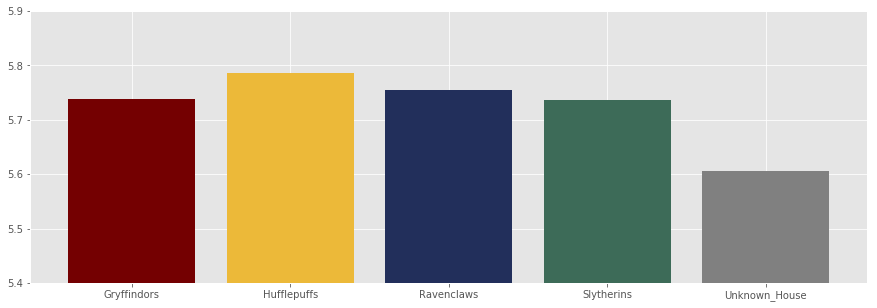

In [39]:
plt.figure(figsize=(15,5))
plt.bar(mean_house_sentiment_dict.keys(), mean_house_sentiment_dict.values(), color=color_list)
plt.ylim(5.4,5.9)

Text(0,0.5,'Count')

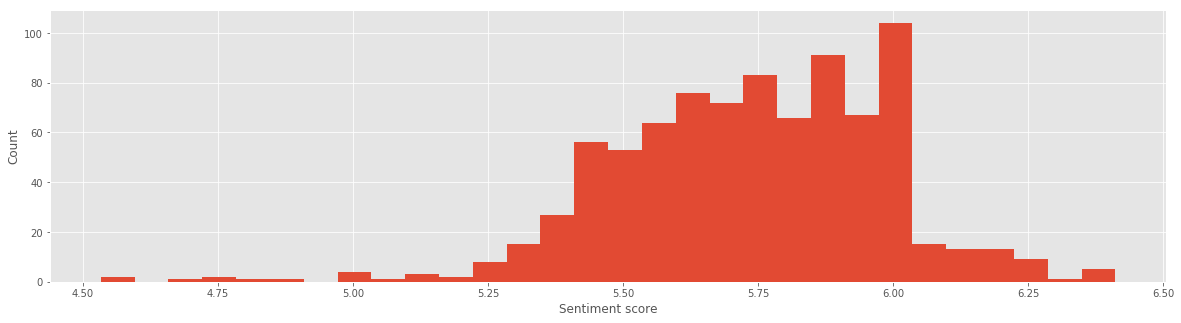

In [40]:
plt.figure(figsize=(20,5))
plt.hist(sentiment_dict.values(), bins=30)
plt.xlabel("Sentiment score")
plt.ylabel("Count")

Text(0,0.5,'Normalized count')

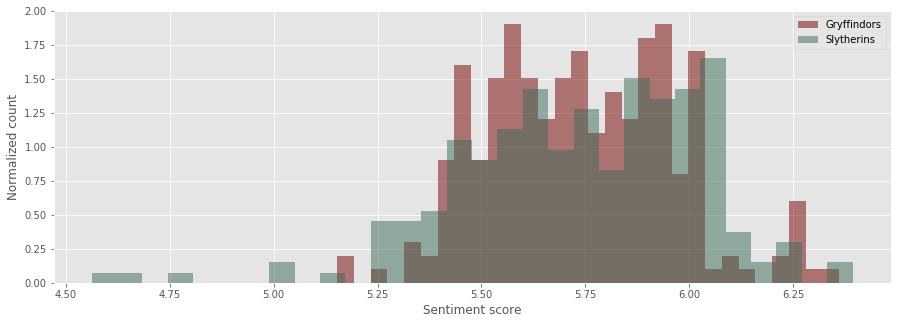

In [41]:
plt.figure(figsize=(15,5))
plt.hist(house_sentiment_dict['Gryffindors'], bins=30, alpha=0.5, color=house_color_dict['Gryffindors'], density=True)
plt.hist(house_sentiment_dict['Slytherins'], bins=30, alpha=0.5, color=house_color_dict['Slytherins'], density=True)
plt.xlabel("Sentiment score")
plt.legend({'Gryffindors' : house_color_dict['Gryffindors'],
            'Slytherins' : house_color_dict['Slytherins']})
plt.ylabel("Normalized count")

# Word clouds

In [147]:
house_word_dict = {house: [w for node in nodes for w in token_dict[node]] for house, nodes, in node_dict.iteritems()}
house_word_set_dict = {house: set(words) for house, words in house_word_dict.iteritems()}
houses = house_word_dict.keys()
no_documents = float(len(houses))

house_idf_dict = {}
house_tf_dict = {}
for house, words in house_word_set_dict.iteritems():
    house_idf_dict[house] = {}
    house_tf_dict[house] = nltk.FreqDist(house_word_dict[house])
    for word in words:
        ds_with_word = np.sum([word in ws for ws in house_word_set_dict.itervalues()])
        house_idf_dict[house][word] = np.log(no_documents / ds_with_word)
        
house_tfidf_dict = {}
for house, words in house_word_set_dict.iteritems():
    house_tfidf_dict[house] = {w: house_idf_dict[house][w]*house_tf_dict[house][w] for w in house_word_set_dict[house]}

In [167]:
def draw_word_cloud(tfidf):
    word_list = [k for k, _, in tfidf.iteritems() for _ in range(int(np.ceil(tfidf[k])))]
    random.shuffle(word_list)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(word_list))
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.grid(False)
    plt.axis('off')

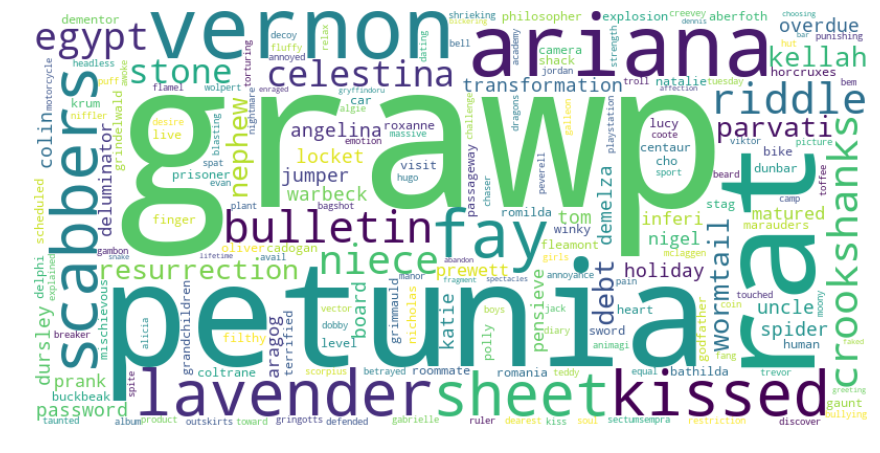

In [168]:
draw_word_cloud(house_tfidf_dict['Gryffindors'])

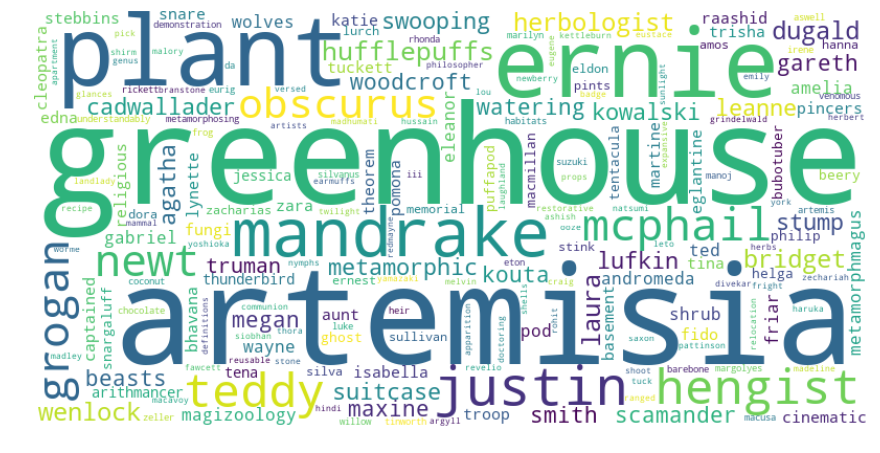

In [169]:
draw_word_cloud(house_tfidf_dict['Hufflepuffs'])

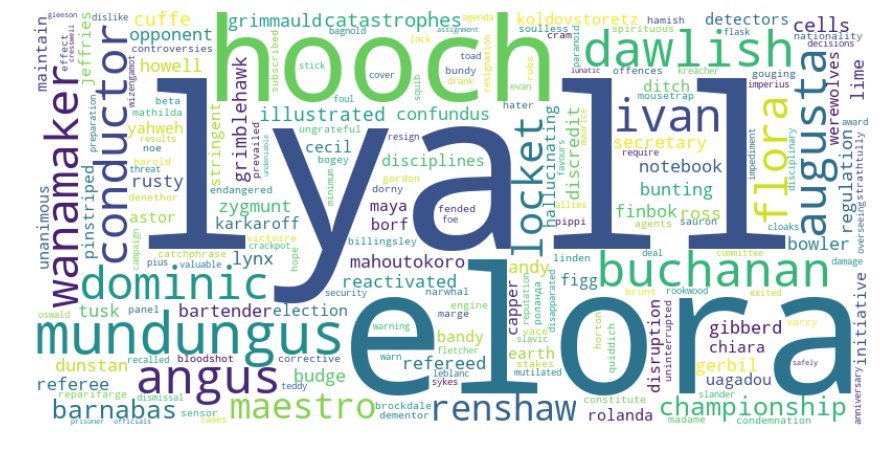

In [170]:
draw_word_cloud(house_tfidf_dict['Unknown_House'])

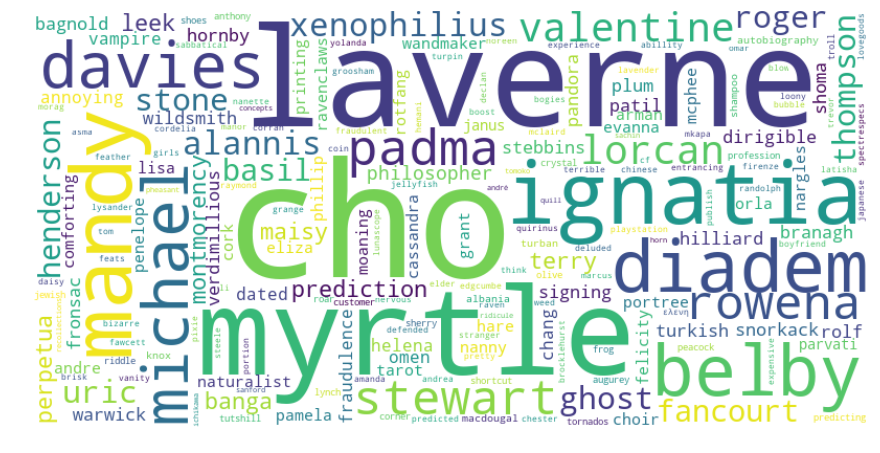

In [171]:
draw_word_cloud(house_tfidf_dict['Ravenclaws'])

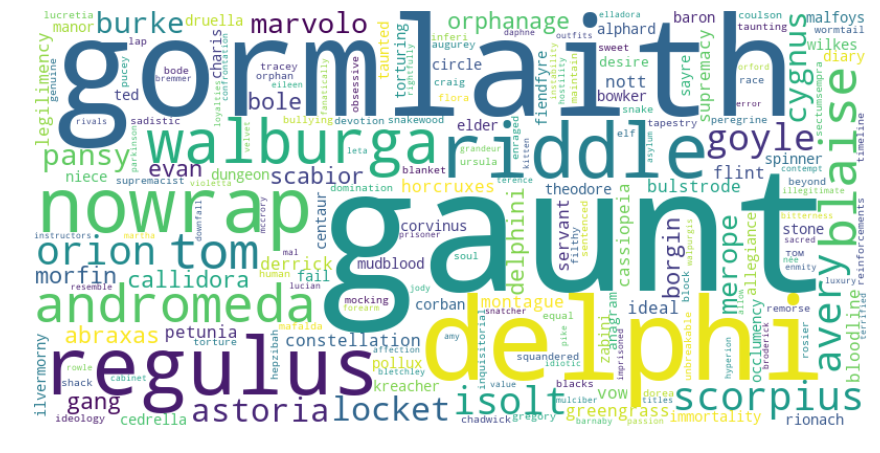

In [172]:
draw_word_cloud(house_tfidf_dict['Slytherins'])